In [6]:
import sympy as sym
import numpy as np
import control as ct
from sympy.integrals import laplace_transform
from sympy.integrals import inverse_laplace_transform
import matplotlib.pyplot as plt

## Symbolic Math

In [35]:
# A Matrix
g =  sym.symbols('g')
K, b, R, L, motor_w = sym.symbols('K, b, R, L, motor_w')
square_mass, wh_mass, wh_rad, d, m_sys =  sym.symbols('m_{sq}, m_{wh}, r_wh, d, m_{sys}')
square_side_len = sym.symbols('l_{sq}')
I_wh, I_sq = sym.symbols('I_wh, I_sq')

In [37]:
A = sym.Matrix([ [0,1,0,0,0],
               [(m_sys*g*d)/(I_sq+2*I_wh),0,0,(-2*b)/(I_sq+2*I_wh),(-2*K)/(I_sq+2*I_wh)],
               [0,0,0,1,0],
               [0,0,0,-b/I_wh,K/I_wh],
               [0,0,0,-K/L,-R/L]
             ])
A

Matrix([
[                          0, 1, 0,                    0,                    0],
[d*g*m_{sys}/(I_sq + 2*I_wh), 0, 0, -2*b/(I_sq + 2*I_wh), -2*K/(I_sq + 2*I_wh)],
[                          0, 0, 0,                    1,                    0],
[                          0, 0, 0,              -b/I_wh,               K/I_wh],
[                          0, 0, 0,                 -K/L,                 -R/L]])

### Contants

In [39]:
g = 9.8 # m/s^2

# Motor Constants
k_t = 0.174 # Nm/A (Motor tourqe constant)
k_b = 0.377 # V/rad/s (Electromotive force constant)
K = k_t 
# "In SI units, the motor torque and back emf constants are equal, that is, $K_t = K_e$; therefore, 
#  we will use $K$ to represent both the motor torque constant and the back emf constant" 
# https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemModeling

b = 4.64e-4 # Nms (Motor viscous friction constant)
R = 6.7      # ohm (Motor electric resistance)
L = 3e-6    # H (Motor electric inductance)
motor_w = 0.098 # kg


# 3D Printed Parts 
square_mass = 0.068 #kg
square_side_len = 0.18 #m 
d = (np.sqrt(2)/2)*square_side_len # Distance to center of square
I_sq =  (2/3)*square_mass*(square_side_len**2) # Inertia Of Square rotated around corner
wh_mass = 0.085 #kg
wh_rad =  0.15 #m
I_wh = ((1/2)*wh_mass*wh_rad**2) + (wh_mass*(d**2))# Inertia Of Wheel + parallel axis

# Other compentents 
circut_board_w = 0.025 #kg 
L298N_w =  0.022 #kg
battery_w = 0.072 #kg

m_sys = square_mass+wh_mass+motor_w+circut_board_w+L298N_w+battery_w #kg
#m_sys = Just Measure final prodcut 

### Create State Space Representation

In [42]:
A = np.array([ [0,1,0,0,0],
               [(m_sys*g*d)/(I_sq+2*I_wh),0,0,(-2*b)/(I_sq+2*I_wh),(-2*K)/(I_sq+2*I_wh)],
               [0,0,0,1,0],
               [0,0,0,-b/I_wh,K/I_wh],
               [0,0,0,-K/L,-R/L]
             ])
B = np.array([0,0,0,0,(1/L)]).reshape(-1, 1)
C = np.array([1,1,1,1,0]).reshape(1, -1)
D = np.array([[0]])

#print(np.shape(A))
#print(np.shape(B))
#print(np.shape(C))
#print(np.shape(D))
sys = ct.ss(A, B, C, D)
sys

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 7.52228015e+01,  0.00000000e+00,  0.00000000e+00,
        -1.51255847e-01, -5.67209427e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.98864245e-01,  7.45740919e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.80000000e+04, -2.23333333e+06]]), array([[     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [333333.33333333]]), array([[1., 1., 1., 1., 0.]]), array([[0.]]))

In [44]:
# Concatenate into controllability matrix
P = ct.ctrb(A,B)

print("Controllability matrix P:")
print(P)

# Check rank
rank = np.linalg.matrix_rank(P)
print(f'The system is controllable: {rank == A.shape[0]}')

Controllability matrix P:
[[ 0.00000000e+00  0.00000000e+00 -1.89069809e+07  4.22255869e+13
  -9.43037291e+19]
 [ 0.00000000e+00 -1.89069809e+07  4.22255869e+13 -9.43037291e+19
   2.10611479e+26]
 [ 0.00000000e+00  0.00000000e+00  2.48580306e+07 -5.55162734e+13
   1.23986236e+20]
 [ 0.00000000e+00  2.48580306e+07 -5.55162734e+13  1.23986236e+20
  -2.76902354e+26]
 [ 3.33333333e+05 -7.44444444e+11  1.66259115e+18 -3.71311702e+24
   8.29262081e+30]]
The system is controllable: False


# Open Loop Response

In [ ]:
#plt.figure(figsize=(10, 8))
#plt.tight_layout()
ct.root_locus_plot(sys)
# Poles Of Plant
print("Open Loop Poles") 
for x in ct.poles(sys):
    print(x)

# Zeros Of Plant
print("Open Loop Zeros")
for x in ct.zeros(sys):
    print(x)

In [ ]:
# Simulate Open Loop Response for 10 seconds
t = np.linspace(0,10,100)
t1, y1, x1= ct.step_response(sys,t,return_x=True)
plt.plot(t1,y1)

# LQR Design

In [46]:
Q = np.eye(sys.A.shape[0])  # identity matrix → penalize all states equally
Q = np.diag(np.array([1,1,1,1,1]))
R = np.array([[10]])              # penalize input moderately

K, S, E = ct.lqr(sys, Q, R)

#print(f'Q:\n{Q}')
#print(f'\nR:\n{R}')
#print(f'\nSolutionto ARE: \n{S}')
#print(f'\nLQR gain: \n{K}')
#print(f'\nClosed-loop poles:')
for x in E:
    print(x)

(-2.2358175e+06+0j)
(-10.244441+0j)
(-7.21653+0j)
(-4.088513+0j)
(-0.87497884+0j)


In [48]:
#LQR System
A_cl = sys.A - (sys.B @ K)
B_cl = sys.B  
C_cl = sys.C
D_cl = sys.D

dt = np.linspace(0, 10, 500)
cl_sys = ct.ss(A_cl, B_cl, C_cl, D_cl)
#cl_sys

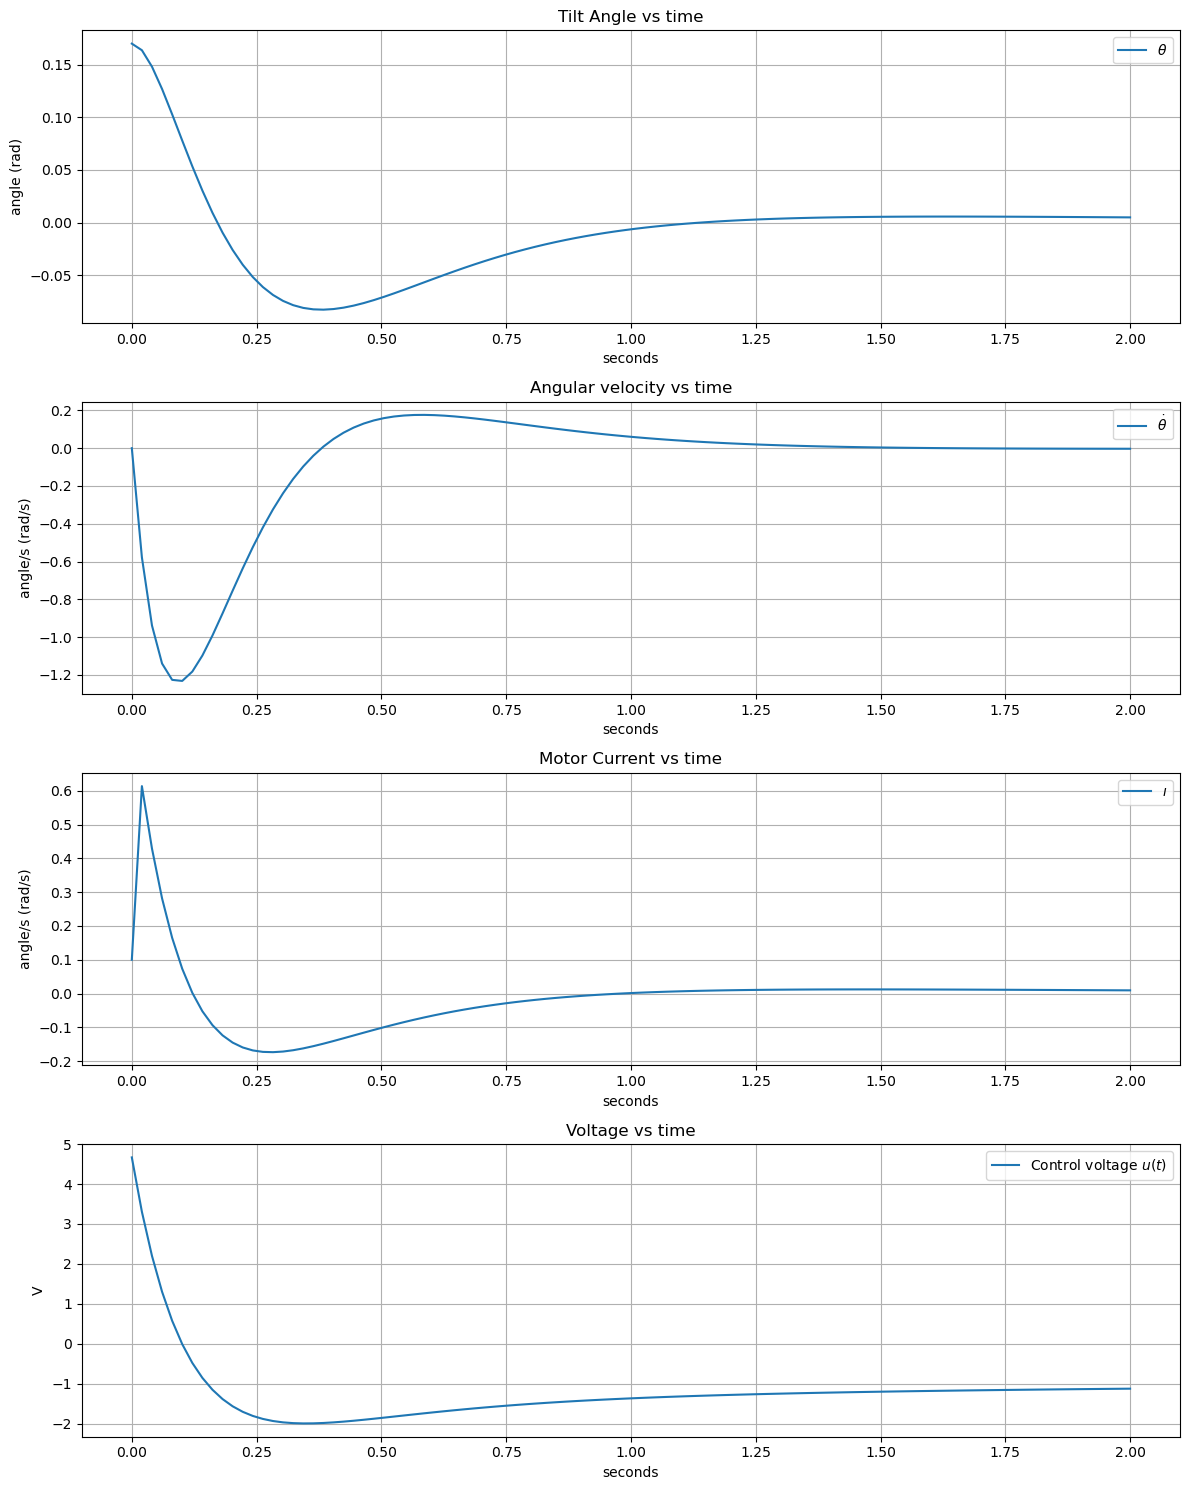

In [135]:
# Simulate Open Loop Response
t = np.linspace(0,2,100)
x0 = np.array([0.17,0,0,0,0.1])
t1, y1, x1 = ct.step_response(cl_sys,t, X0=x0, return_x=True)

# Compute control voltage over time
u = -K @ x1  # shape: (1, len(t))

# Tilt Angle
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
plt.plot(t1,x1[0,:], label = r'$\theta$')
plt.title('Tilt Angle vs time')
plt.xlabel('seconds')
plt.ylabel('angle (rad)')
plt.legend(loc="upper right")
plt.grid(True)

# Theta_d
plt.subplot(4, 1, 2)
plt.plot(t1,x1[1,:], label = r'$\dot{\theta}$')
plt.title('Angular velocity vs time')
plt.xlabel('seconds')
plt.ylabel('angle/s (rad/s)')
plt.legend(loc="upper right")
plt.grid(True)

# Current
plt.subplot(4, 1, 3)
plt.plot(t1,x1[4,:], label = r'$\i$')
plt.title('Motor Current vs time')
plt.xlabel('seconds')
plt.ylabel('Ampere')
plt.legend(loc="upper right")
plt.grid(True)

# Control 
plt.subplot(4, 1, 4)
plt.plot(t1, u[0, :], label='Control voltage $u(t)$')
plt.title('Voltage vs time')
plt.xlabel('seconds')
plt.ylabel('V')
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.savefig("open_loop_response.png", dpi=300, bbox_inches='tight')
plt.show()


#plt.plot(t1,x1[0,:], label = r'$\theta$')
#plt.plot(t1,x1[1,:], label = r'$\dot{\theta}$')
#plt.plot(t1,x1[2,:], label = r'$\phi$')
#plt.plot(t1,x1[3,:], label = r'$\dot{\phi}$')
#plt.plot(t1,x1[4,:], label = r'$\i$')


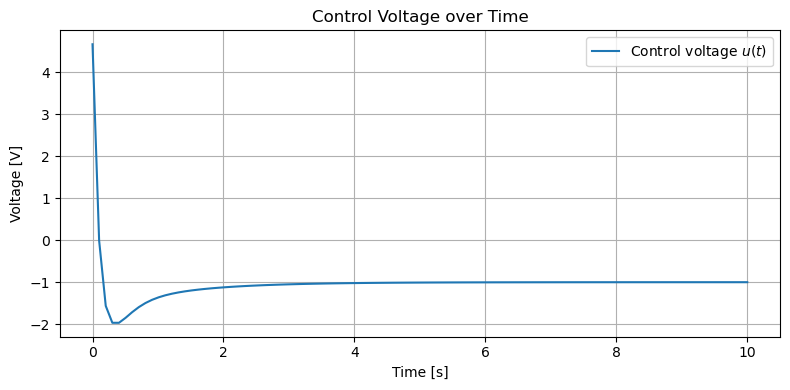

In [117]:
# Compute control voltage over time
u = -K @ x1  # shape: (1, len(t))
t = np.linspace(0,2,100)
plt.figure(figsize=(8,4))
plt.plot(t1, u[0, :], label='Control voltage $u(t)$')
plt.title('Control Voltage over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
u[0][0:10]

array([ 4.66748166,  3.30527277,  2.20053921,  1.30333348,  0.57701597,
       -0.00866271, -0.4786811 , -0.8536682 , -1.15066218, -1.38373545])

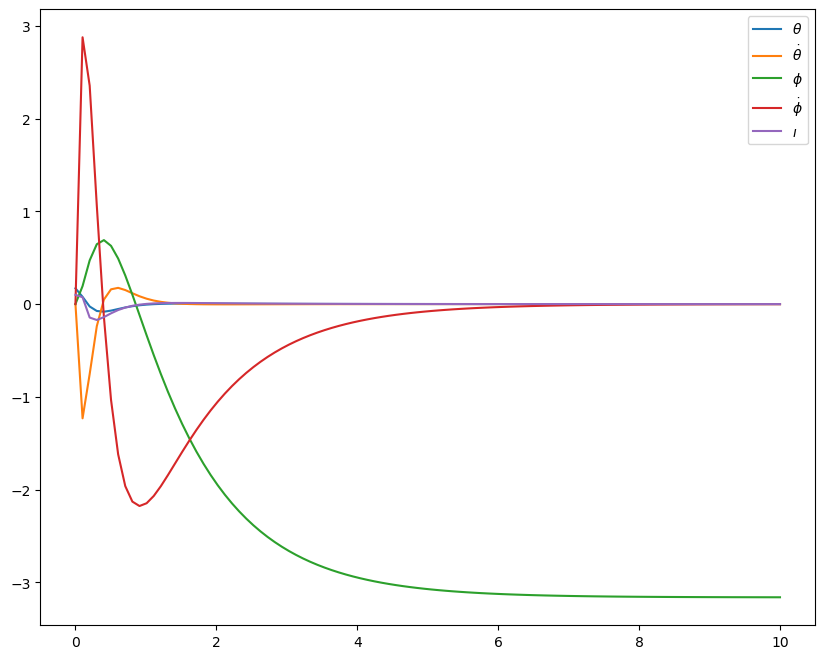

In [109]:
# Simulate Open Loop Response for 10 seconds
t = np.linspace(0,10,100)
x0 = np.array([0.17,0,0,0,0.1])
t1, y1, x1 = ct.step_response(cl_sys,t, X0=x0, return_x=True)
#plt.plot(t1,y1)

plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.plot(t1,x1[0,:], label = r'$\theta$')
plt.plot(t1,x1[1,:], label = r'$\dot{\theta}$')
plt.plot(t1,x1[2,:], label = r'$\phi$')
plt.plot(t1,x1[3,:], label = r'$\dot{\phi}$')
plt.plot(t1,x1[4,:], label = r'$\i$')
plt.legend(loc="upper right")

In [111]:
K

array([[-2.74601976e+01, -3.18167437e+00, -3.16232725e-01,
        -5.94907527e-01,  7.51940864e-03]])

In [113]:
np.set_printoptions(suppress=True, precision=6)
print(K)
np.set_printoptions(suppress=False)

[[-27.460198  -3.181674  -0.316233  -0.594908   0.007519]]


In [115]:
K

array([[-2.746020e+01, -3.181674e+00, -3.162327e-01, -5.949075e-01,
         7.519409e-03]])

In [ ]:
plt.figure()
plt.scatter(np.real(E), np.imag(E), marker='x', color='red')
plt.title('Closed-loop poles')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.show()